# TIØ4317 - Empirical and Quantitative Methods in Finance - Project
## Problem Statement

Wholesale electricity prices are known to be difficult to forecast accurately due to their inherent complexity. Prices often exhibit rapid short-term fluctuations, strong seasonal patterns in demand, and occasional sharp spikes triggered by factors such as weather events or changes in fuel prices. Accurate day-ahead forecasts of electricity prices are therefore crucial for market participants including utilities, traders, and industrial consumers. Reliable forecasts enable these stakeholders to effectively manage risk, optimize their operational decisions, and reduce costs associated with balancing energy supply and demand. Conversely, inaccurate predictions can result in substantial financial losses and operational inefficiencies, emphasizing the importance of developing robust forecasting models that are thoroughly validated.

This project addresses the forecasting of daily wholesale electricity prices using publicly available data provided by the United States Energy Information Administration (EIA). Given the presence of trends, seasonal patterns, and significant autocorrelation in electricity prices, our study employs ARIMA-based models. In certain instances, these models are expanded to include seasonal components to better represent repeating patterns and address non-stationary behaviour within the data. Additionally, we incorporate exogenous dummy variables representing summer and winter months to explicitly capture seasonal effects that might influence price fluctuations. The methodology consists of verifying stationarity using ADF and KPSS tests, selecting the most suitable ARIMA specifications guided by the AIC and BIC, and validating the models through rolling-window forecasts for the year 2024.

By systematically exploring and comparing several ARIMA model variants, including different AR and moving-average MA orders, seasonal structures, and exogenous regressors, we aim to determine the most effective approach for generating accurate short-term electricity price forecasts. The predictive performance of these models is benchmarked against a simple naive forecast, which assumes today’s price will be identical to yesterdays. Evaluation metrics used include mean absolute error (MAE) and root mean squared error (RMSE). Through this comparative analysis, the study aims to provide insights into both the potential advantages and inherent limitations of ARIMA-based modelling approaches in practical electricity price forecasting contexts.


## Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

To prepare the dataset for analysis, we compiled and merged daily electricity price data from multiple Excel files covering the years 2015 to 2024. Each file contained prices from several regional hubs, stored in a long format. For each year, we extracted the weighted average price per megawatt-hour for each hub and reshaped the data into a wide format with trade dates as rows and one column per price hub. The resulting annual datasets were then merged on the trade date to form a unified time series covering all hubs. We ensured consistent datetime formatting, handled duplicate entries, and dropped the 2014 data due to inconsistencies in hub naming. The cleaned dataset was saved as a single file and used as the starting point for the modeling stage.

In [3]:
el_prices = pd.read_excel(r'C:\TIO4317_spring25_project\TIO4317_spring25_project\data\Processed\ice_electric-ave_price-2015-2025.xlsx')
el_prices.set_index('Trade date', inplace=True)

#### Exploratory analysis 
To begin the analysis, we plotted the raw daily prices for the PJM WH Real Time Peak hub over the full period from 2015 to 2024. The time series reveals a clear pattern of recurring price spikes, many of which cluster around the winter months, likely driven by seasonal increases in electricity demand. From 2021 onward, the price dynamics appear notably more volatile, with both higher peaks and greater variation from day to day. This shift may reflect broader changes in market conditions, such as increased sensitivity to fuel prices, supply chain constraints, or extreme weather events. The combination of sharp short-term fluctuations and potential seasonal patterns underscores the need for models that can capture both volatility and time-dependent structure in the data.

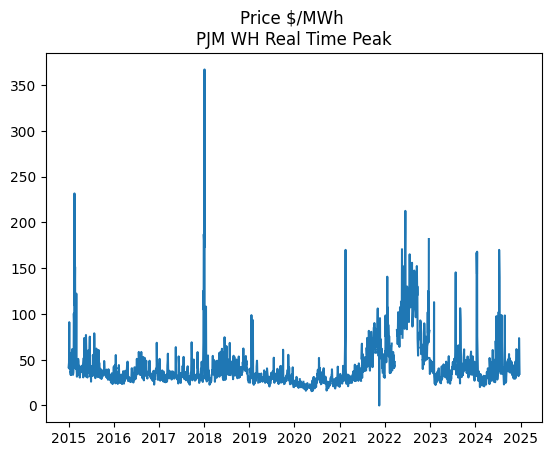

In [4]:
plt.figure()
plt.plot(el_prices["Price $/MWh \nPJM WH Real Time Peak"])
plt.title("Price $/MWh \nPJM WH Real Time Peak")
plt.show()

For the modeling stage, we selected the “PJM WH Real Time Peak” price series from the cleaned dataset. This hub was chosen due to its consistent data coverage and relevance as a representative wholesale electricity market. To prepare the series for time-series analysis, we first resampled it to a business-day frequency, ensuring that all weekdays were represented. Any missing values resulting from this resampling were filled using nearest-neighbor interpolation, which preserves local price patterns without introducing artificial trends. Finally, any remaining missing observations were removed to ensure the continuity and integrity of the series before applying statistical tests and model fitting.

In [5]:
el_price_PJM = el_prices["Price $/MWh \nPJM WH Real Time Peak"].asfreq('B')
el_price = el_price_PJM.interpolate(method='nearest').dropna() 

#### Stationarity 

A fundamental requirement for many time-series models, including ARIMA, is that the input series is stationary. A stationary time series is one whose statistical properties, such as mean, variance, and autocorrelation do not change over time. Non-stationary series often exhibit trends, seasonal fluctuations, or structural shifts that can distort model estimates and reduce forecasting accuracy. For this reason, testing for stationarity is a crucial step before specifying and estimating the model.

To evaluate whether the electricity price series is stationary, we first applied an ADF test. The ADF test checks for the presence of a unit root, with the null hypothesis being that the series is non-stationary. The test yielded a test statistic of -4.7867 and a p-value of 0.0001, which is well below the conventional 5% significance level. Additionally, the test statistic was more negative than the critical values at the 1%, 5%, and 10% levels. Based on this result, we reject the null hypothesis and conclude that the series does not contain a unit root. This suggests that, according to the ADF test, the original price series is stationary and may not require differencing prior to modeling.

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if result[1] < 0.05:
        print("Conclusion: The series is likely stationary.")
    else:
        print("Conclusion: The series is likely non-stationary.")

In [7]:
adf_test(el_price)

ADF Statistic: -4.7867
p-value: 0.0001
Critical Values:
   1%: -3.4329
   5%: -2.8627
   10%: -2.5674
Conclusion: The series is likely stationary.


The conclusion of stationarity from the ADF test was somewhat unexpected, especially considering the visual impression from the exploratory plot. The raw price series showed clear signs of structural patterns, including large price spikes, potential seasonal effects, and changing volatility, features that are often associated with non-stationarity. In particular, the increased volatility and apparent shifts in price levels after 2021 raised concerns about underlying trends or time-varying properties in the series.

To investigate this further, we applied an additional test: a KPSS test. Unlike the ADF test, which tests the null hypothesis of a unit root (non-stationarity), the KPSS test assumes that the series is stationary under the null and tests for the presence of a trend or unit root as the alternative. By using both tests, which take opposing hypotheses, we can form a more robust and balanced assessment of the series’ stationarity.

In [8]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series):
    result = kpss(series.dropna(), regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend stationarity
    print(f'KPSS Statistic: {result[0]}')
    print(f'P-value: {result[1]}')
    print(f'Critical Values: {result[3]}')
    if result[1] < 0.05:
        print("Reject null hypothesis: The series is likely non-stationary.")
    else:
        print("Fail to reject null hypothesis: The series is likely stationary.")

In [9]:
kpss_test(el_price)

KPSS Statistic: 1.121576119326783
P-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject null hypothesis: The series is likely non-stationary.


C:\Users\endre\AppData\Local\Temp\ipykernel_18840\2214210753.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend stationarity


The KPSS test strongly rejected the null hypothesis of stationarity, with a test statistic of 1.12 and a p-value below 0.01. This result aligns with the expectations formed from the exploratory analysis and contrasts with the outcome of the ADF test. Given this, we proceed under the assumption that the original price series is non-stationary.

To address this, we next apply the same tests to the first-differenced series to assess whether differencing is sufficient to achieve stationarity.

In [10]:
el_price_diff = el_price.diff().dropna().asfreq('B')

In [11]:
adf_test(el_price_diff)
print("---------------------------")
kpss_test(el_price_diff)


ADF Statistic: -14.5007
p-value: 0.0000
Critical Values:
   1%: -3.4329
   5%: -2.8627
   10%: -2.5674
Conclusion: The series is likely stationary.
---------------------------
KPSS Statistic: 0.030600630755135447
P-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject null hypothesis: The series is likely stationary.


C:\Users\endre\AppData\Local\Temp\ipykernel_18840\2214210753.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend stationarity


The differenced series is likely stationary. Therefore, d=1 in ARIMA. 

To confirm whether first-order differencing was sufficient to achieve stationarity, we applied the same stationarity tests to the differenced price series. The ADF test strongly rejected the null hypothesis of a unit root, with a test statistic of -14.50 and a p-value effectively equal to zero. The KPSS test, which tests the opposite null hypothesis of stationarity, failed to reject the null, returning a test statistic of 0.031, well below even the 10% critical value. With both tests now supporting the conclusion of stationarity, we proceed with the differenced series for modeling. This justifies setting the differencing parameter d = 1 in the ARIMA model.

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error,mean_absolute_error

## Empirical analysis

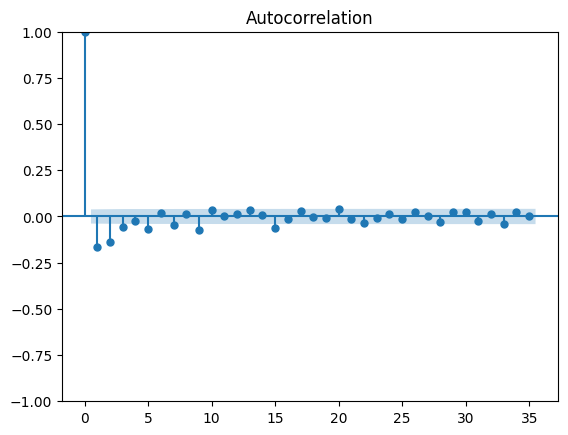

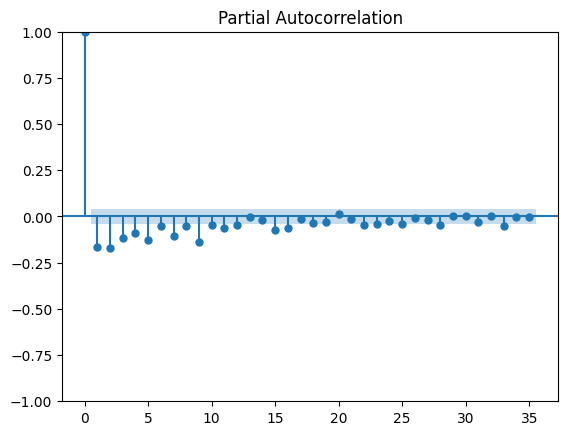

In [13]:
plot_acf(el_price_diff.dropna())
plot_pacf(el_price_diff.dropna())
plt.show()

#### Parameter selection

To guide the specification of an appropriate ARIMA model, we began by examining the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots for the first-differenced data. The ACF plot shows significant spikes at the first few four lags, suggesting that the inclusion of multiple moving average (MA) terms could improve the model fit. Similarly, the PACF plot indicates significant partial autocorrelation up to approximately lag 9, implying that autoregressive (AR) terms might be relevant. These plots notwithstanding, excessive lag inclusion risks overspecification. This can, inter alia, result in worse out-of-sample performance. As such, we must evaluate whether the additional explanatory power justifies increasing model complexity.

To this end, we examined various values of p and q (see below) to see the performance of various specifications with respect to a selection of information criteria.

p → Autoregressive (AR) term (from PACF plot)\
d → Number of differences needed to achieve stationarity\
q → Moving average (MA) term (from ACF plot) 

In [14]:
import warnings

In [15]:
def arima_info_criteria(y, d=1, max_p=5, max_q=5):
    results = []

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")  # Suppress all warnings

                    model = ARIMA(y, order=(p, d, q)).fit()

                # Explicit convergence check
                converged = model.mle_retvals.get("converged", True)

                if not converged:
                    print(f"⚠️ ARIMA({p},{d},{q}) did not converge.")
                    continue

                results.append({
                    "p": p,
                    "q": q,
                    "AIC": model.aic,
                    "BIC": model.bic,
                    "HQIC": model.hqic
                })

            except Exception as e:
                # Uncomment if you want to debug specific errors
                # print(f"❌ ARIMA({p},{d},{q}) failed: {e}")
                continue

    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
results_df = arima_info_criteria(el_price)
AIC_result = results_df.sort_values("AIC")
BIC_result = results_df.sort_values("BIC")
BIC_result = results_df.sort_values("HQIC")

⚠️ ARIMA(3,1,3) did not converge.
⚠️ ARIMA(3,1,5) did not converge.
⚠️ ARIMA(4,1,3) did not converge.
⚠️ ARIMA(4,1,4) did not converge.
⚠️ ARIMA(5,1,3) did not converge.
⚠️ ARIMA(5,1,4) did not converge.
⚠️ ARIMA(5,1,5) did not converge.


#### Information criteria

To further inform model selection and avoid overspecification, we estimate a grid of ARIMA models with varying combinations of p and q terms. These were then evaluated based upon the three most commonly used information criteria: AIC, BIC, and HQIC. These information criteria penalise model complexity to balance model fit against the risk of overspecification.

In [17]:
AIC_result.head()

,p,q,AIC,BIC,HQIC
21,3,4,20864.839167,20911.751452,20881.835965
17,2,5,20867.030068,20913.942354,20884.026867
28,5,2,20868.052903,20914.965188,20885.049701
25,4,5,20868.624709,20927.265065,20889.870707
16,2,4,20869.086054,20910.134304,20883.958253


##### AIC
AIC favours a relatively complex model where the autoregressive term, p, is 3 and the moving average term, q, is 4. This is in line with expectations, as AIC tends to punish complexity less than the other criteria. On the basis of AIC we would use an ARIMA(3,1,4) specification. However, we also examine the results with respect to the other information criteria to inform our model specification.

In [18]:
BIC_result.head()

,p,q,AIC,BIC,HQIC
7,1,1,20872.752875,20890.344982,20879.126674
8,1,2,20874.544481,20898.000624,20883.042881
13,2,1,20874.562213,20898.018356,20883.060613
14,2,2,20872.212930,20901.533108,20882.835929
19,3,1,20874.813828,20904.134006,20885.436827


##### BIC
In contrast to AIC, the Bayesian Information Criterion (BIC) prefers a simpler model. If we were to specify the model to optimise BIC, we would use an ARIMA(1,1,1) model. As the results from AIC and BIC are equivocal, we must make an evaluation as to how we weigh their respective choices. First, however, we evaluate the final information criterion used in this analysis.

In [ ]:
HQIC_result.head()

##### HQIC
HQIC, similar to BIC, favours an ARIMA(1,1,1) specification due to its stronger penalty on model complexity relative to AIC.

##### Information Criteria Conclusion
Given the risk of overfitting associated with the AIC-preferred model, and the relatively modest gains in AIC relative to BIC's preferred model, we proceed with the ARIMA(1,1,1) specification. We believe this is the most parsimonious model to fit to our data, as it seems to capture the essential dynamics of price series while mjinimising the risk of overfitting

In [27]:
#Model 1 ARIMA(1,1,1)
p,d,q = 1,1,1

model = ARIMA(el_price, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Price $/MWh 
PJM WH Real Time Peak   No. Observations:                 2603
Model:                                 ARIMA(1, 1, 1)   Log Likelihood              -10433.376
Date:                                Thu, 10 Apr 2025   AIC                          20872.753
Time:                                        14:30:27   BIC                          20890.345
Sample:                                    01-02-2015   HQIC                         20879.127
                                         - 12-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6464      0.009     71.382      0.000       0.629       0.664
ma.

#### Residual diagnostics 
Ljung box test for autocorrelation: 
H_0: No autocorrelation
test statistic: 0.07, and p-value = 0.79.
Cannot reject the null, and the residuals are not significantly autocorrelated. 

The test for heteroskedasticity is the ARCH LM test. 
H_0: homoskedasticity. 
Test statistic: H=1.11 
p-value = 0.11
The result fails to reject the null hypothesis, and therefore there is no strong evidence of ARCH effects. 

Normality test is done with the Jarque-Bera test: 
H_0: normality of residuals. 
test statistic: 503,133
p-value = 0.00 
Therefore, we can reject the null, and conclude that the residuals are not normally distributed. 

For the skewness of 2.44, the residual distribution is pushed to the right. The high kurtosis of 71 indicates that the residuals have heavy tails and therefore more outliers. The histogram below shows the distribution of residuals. 

For using the model for forecasting it is robust to non-normal residuals as long as they are uncorrelated and have constant variance. 


#### Model Results
##### ARIMA(1,1,1)
Having selected the ARIMA(1,1,1) specification, we estimate the model on the sample of electricity prices. All estimated coefficients are statistically significant at the 5% level. The AR(1) term has a positive coefficient, suggesting there is some peristance in price changes. That is, increases in the previous period tend to be followed by more movements in the same direction. Converesly, the MA(1) term is negative, indicated that shocks are often partially 'corrected' in the subsequent period.

Residual diagnostics also provide additional insight into the model fit. The JB test, as well as the high kurtosis, suggest fatter tails than would be expected for a normal distribution. This suggests that large movements in prices happen more often than a normal distribution would predict.

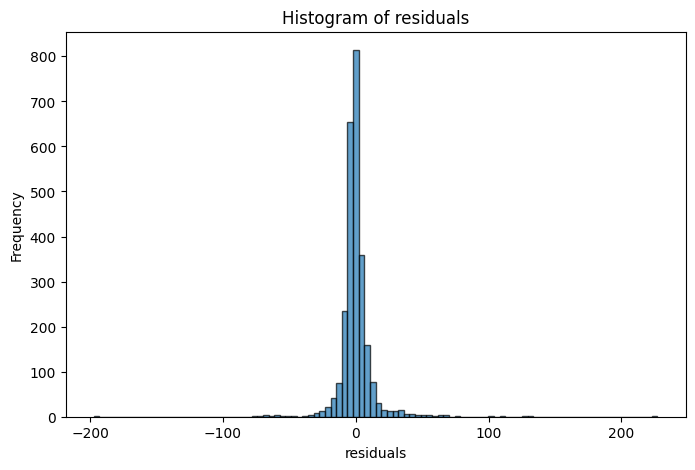

In [25]:
plt.figure(figsize=(8, 5))
plt.hist(model_fit.resid, bins=100, edgecolor='black', alpha=0.7)
plt.title("Histogram of residuals")
plt.xlabel("residuals")
plt.ylabel("Frequency")
plt.show()

In [72]:
#Model 2 ARIMA(3,1,4)
p,d,q = 3,1,4

model = ARIMA(el_price, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Price $/MWh 
PJM WH Real Time Peak   No. Observations:                 2603
Model:                                 ARIMA(3, 1, 4)   Log Likelihood              -10424.420
Date:                                Sun, 06 Apr 2025   AIC                          20864.839
Time:                                        17:10:52   BIC                          20911.751
Sample:                                    01-02-2015   HQIC                         20881.836
                                         - 12-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8521      0.119     -7.169      0.000      -1.085      -0.619
ar.

##### ARIMA(3,1,4)
As ARIMA(3,1,4) is the specification favoured by AIC, we estimate this model to facilitate comparison with the simpler ARIMA(1,1,1) specification. This model has increased flexibility, and can map onto a more complex dynamic structure, and as such achieves a lower AIC. All autoregressive and moving average terms are statistically significant, suggesting that the additional lags do explain some variation in the data.

Nevertheless, the improvement in model fit is relatively modest when weighed against the substantial increase in model complexity. The BIC, which applies a stronger penalty for additional parameters, increases considerably for the ARIMA(3,1,4) model. Moreover, the residual variance is only slightly lower than in the ARIMA(1,1,1) model despite using significantly more parameters.

Given these considerations, we conclude that the simpler ARIMA(1,1,1) model strikes a more appropriate balance between parsimony and explanatory power. The gains from increased complexity do not, in our view, justify the higher risk of overfitting.

In [16]:
#How many dates are in a year: 
np.average(el_price.index.year.value_counts())

np.float64(260.3)

In [17]:
#Model SARIMA(1,0,1)(1,0,0)s=260 
#Considering a pattern repeating each year. 

p,d,q = 1,1,1

P,D,Q,s = 1,0,0,260

model = ARIMA(el_price[2000:], order=(p, d, q),seasonal_order=(P,D,Q,s))
model_fit = model.fit()

print(model_fit.summary())

c:\Users\endre\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                       SARIMAX Results                                        
Dep. Variable:     Price $/MWh 
PJM WH Real Time Peak   No. Observations:                  603
Model:                 ARIMA(1, 1, 1)x(1, 0, [], 260)   Log Likelihood               -2491.762
Date:                                Thu, 10 Apr 2025   AIC                           4991.524
Time:                                        12:24:20   BIC                           5009.125
Sample:                                    09-02-2022   HQIC                          4998.375
                                         - 12-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6312      0.026     23.831      0.000       0.579       0.683
ma.

#### Seasonality
##### Annual Seasonality (s=260)

To investigate the potential presence of annual seasonality in electricity prices, we first consider a SARIMA specification with a seasonal lag of 260. This corresponds to the average number of unique dates with data per year in our dataset. The rationale for this specification is that electricity prices may exhibit recurring patterns on an annual basis due to weather, demand, and supply conditions.

However, the results for the s=260 model do not provide strong support for such a seasonal effect. While the model achieves an AIC almost identical to the baseline ARIMA(1,1,1) specification, the seasonal autoregressive term at lag 260 is not statistically significant (p = 0.371). Moreover, the model is computationally intensive and slow to estimate. Given the lack of clear statistical evidence and the computational cost associated with this approach, we preclude the use of the s=260 model.

In [ ]:
p,d,q = 1,1,1

P,D,Q,s = 4,0,0,65

model = ARIMA(el_price[2000:], order=(p, d, q),seasonal_order=(P,D,Q,s))
model_fit = model.fit()

print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Price $/MWh 
PJM WH Real Time Peak   No. Observations:                  603
Model:                  ARIMA(1, 1, 1)x(4, 0, [], 65)   Log Likelihood               -2486.193
Date:                                Sun, 06 Apr 2025   AIC                           4986.386
Time:                                        20:49:16   BIC                           5017.188
Sample:                                    09-02-2022   HQIC                          4998.375
                                         - 12-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6319      0.028     22.790      0.000       0.578       0.686
ma.

>

##### Intra-year Seasonality (s=65)

As a compromise between capturing seasonal dynamics and maintaining model tractability, we next consider a SARIMA specification with s=65, corresponding approximately to a quarter. This reduces the length of the seasonal lag while still allowing for intra-year patterns to be captured.

The results of the ARIMA(1,1,1)x(4,0,[],65) model provide some evidence of intra-year seasonality. While most seasonal lags are not statistically significant, the coefficient at lag 130 (corresponding to a half-year period) is statistically significant at the 5% level. This suggests some persistence in price changes over a half-year horizon, possibly reflecting recurring patterns in demand or supply conditions.

Nevertheless, the model fit remains comparable to the simpler ARIMA(1,1,1) specification, and the estimation time increases noticeably with higher seasonal lags. As such, we explored alternative methods for incorporating seasonal information in a computationally efficient manner.

In [13]:
df = pd.DataFrame({'price': el_price})
df['month'] = df.index.month

# Define summer and winter months 
summer_months = [6, 7, 8]
winter_months = [12,1,2]
# Create a dummy variable for summer
df['is_summer'] = df['month'].isin(summer_months).astype(int)
df['is_winter'] = df['month'].isin(winter_months).astype(int)


endog = el_price
exog = df[['is_summer',"is_winter"]]

p,d,q = 1,1,1

model = ARIMA(endog, order=(p, d, q),exog=exog)
model_fit = model.fit()

print(model_fit.summary()) 


                                       SARIMAX Results                                        
Dep. Variable:     Price $/MWh 
PJM WH Real Time Peak   No. Observations:                 2603
Model:                                 ARIMA(1, 1, 1)   Log Likelihood              -10433.204
Date:                                Thu, 10 Apr 2025   AIC                          20876.407
Time:                                        12:13:46   BIC                          20905.727
Sample:                                    01-02-2015   HQIC                         20887.030
                                         - 12-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_summer     -0.3914      1.915     -0.204      0.838      -4.144       3.361
is_

##### Seasonal Dummy Variables

Given the challenges associated with high-order seasonal ARIMA models, we consider a more direct approach to modelling seasonality using dummy variables for is_summer (June-August) and is_winter (December-February). The rationale for this approach is that broad seasonal patterns, such as higher winter demand or lower summer prices, may still hold despite day-to-day noise.

While the seasonal dummy variables are not statistically significant (p-values of 0.838 and 0.730, respectively), we believe this is due to the model being specified in first differences, which captures changes rather than levels. Moreover, substantial market disturbances (notably the energy crisis of 2021–2022) may have introduced additional volatility, obscuring typical seasonal effects in our sample.

Despite the lack of statistical significance, this approach provides a conceptually sound and computationally efficient way of incorporating seasonal information. We therefore retain the seasonal dummy variable model for further analysis.

In [ ]:
# testing with monthly dummies

df = pd.DataFrame({'price': el_price})
df['month'] = df.index.month

# Generate monthly dummies (excluding one to avoid multicollinearity)
monthly_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)

# Prepare endogenous and exogenous variables
endog = el_price
exog = monthly_dummies

# Fit ARIMA(1,1,1) with monthly dummies
p, d, q = 1, 1, 1
model = ARIMA(endog, order=(p, d, q), exog=exog)
model_fit = model.fit()

print(model_fit.summary())

##### Monthly Dummy Variables
As a final approach, we consider whether increased granularity might better capture seasonal effects by including monthly dummy variables. However, the results provide little evidence of systematic seasonal variation in price changes. None of the monthly coefficients are statistically significant at the 5% level, and the added model complexity does not yield meaningful improvements in model fit.

Given the trade-off between model complexity and practical performance, we reject the monthly dummy variable model in favour of the more parsimonious seasonal dummy specification.


##### Conclusion
Electricity prices exhibit a high degree of non-seasonal noise, and any seasonality present may not align precisely with fixed calendar dates. Furthermore, recent market disturbances may have further obscured typical seasonal patterns. While high-order seasonal ARIMA models provide some evidence of intra-year seasonality, they are computationally intensive and offer limited improvement over simpler specifications.

Given these considerations, we retain the seasonal dummy variable model, as it provides a conceptually sound and computationally efficient method of incorporating seasonal effects into our analysis.

#### Forecast and model performance

##### Model 1: ARIMA(1,1,1)

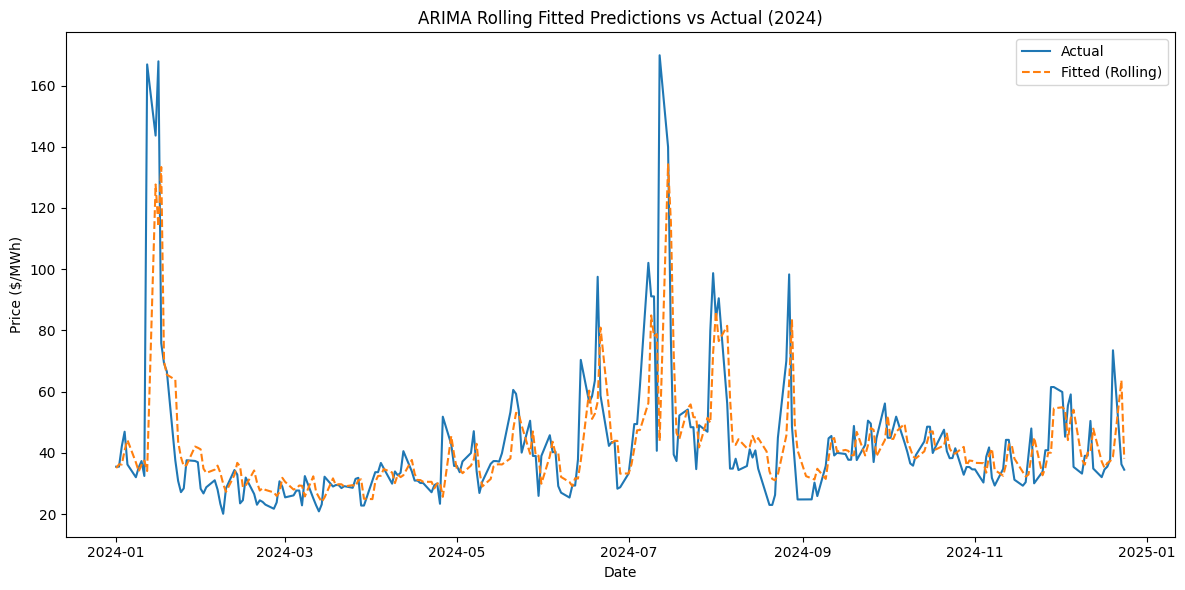

In [74]:
train = el_price[:'2023-12-31']
test = el_price['2024-01-01':]

p,d,q = 1,1,1


history = list(train)
predictions = []

# Rolling forecast
for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)[0]
    predictions.append(forecast)

    # Add the actual value from test to history
    history.append(test.iloc[t])

# Convert to series for plotting
pred_series_1 = pd.Series(predictions, index=test.index)


plt.figure(figsize=(12,6))
plt.plot(test, label='Actual')
plt.plot(pred_series_1, label='Fitted (Rolling)', linestyle='--')
plt.title('ARIMA Rolling Fitted Predictions vs Actual (2024)')
plt.xlabel('Date')
plt.ylabel('Price ($/MWh)')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
#Forecast evaluation. 

mse = mean_squared_error(test, pred_series_1)
mae = mean_absolute_error(test, pred_series_1)
rmse = np.sqrt(mse)
print(f'Rolling Fitted MSE: {mse:.2f}')
print(f'Rolling Fitted MAE: {mae:.2f}')
print(f'Rolling Fitted RMSE: {rmse:.2f}')

Rolling Fitted MSE: 278.04
Rolling Fitted MAE: 8.64
Rolling Fitted RMSE: 16.67


In [76]:
naive_pred = test.shift(1).dropna()  # yesterday = today forecast
naive_true = test[1:]                # actuals aligned

naive_mae = mean_absolute_error(naive_true, naive_pred)
naive_rmse = np.sqrt(mean_squared_error(naive_true, naive_pred))

print(f'Naive MAE: {naive_mae:.2f}')
print(f'Naive RMSE: {naive_rmse:.2f}')

Naive MAE: 8.63
Naive RMSE: 17.71


##### ARIMA(1,1,1) Forecast Evaluation

The ARIMA(1,1,1) model provides a reasonable baseline for forecasting electricity prices. The rolling forecast captures the broad dynamics of the price series, including seasonal fluctuations and volatility spikes, although extreme values are somewhat smoothed. 

Forecast evaluation shows that the model performs comparably to the naive benchmark, with nearly identical MAE and RMSE values. This is consistent with expectations for highly volatile series like electricity prices, where short-term price changes are difficult to predict. While the ARIMA model does not materially outperform the naive benchmark in terms of error metrics, it nevertheless provides a structured approach to modelling the data and forms a useful basis for further model development.

##### Model 2 ARIMA(3,1,4)

c:\Users\endre\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


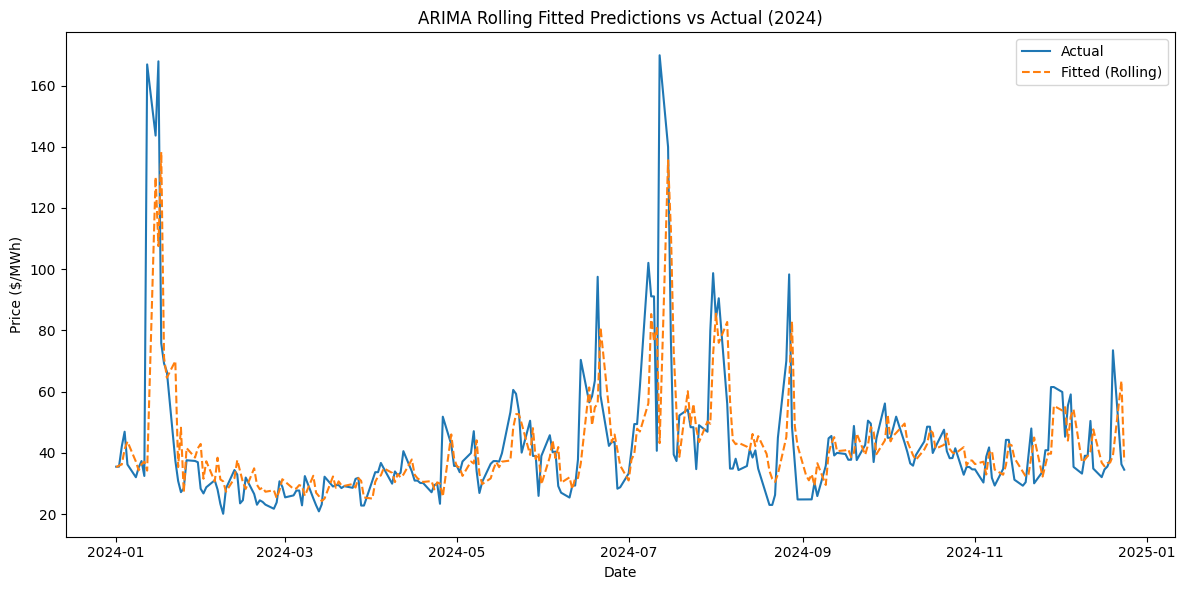

In [69]:
train = el_price[:'2023-12-31']
test = el_price['2024-01-01':]

p,d,q = 3,1,4


history = list(train)
predictions = []

# Rolling forecast
for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)[0]
    predictions.append(forecast)

    # Add the actual value from test to history
    history.append(test.iloc[t])

# Convert to series for plotting
pred_series_2 = pd.Series(predictions, index=test.index)


plt.figure(figsize=(12,6))
plt.plot(test, label='Actual')
plt.plot(pred_series_2, label='Fitted (Rolling)', linestyle='--')
plt.title('ARIMA Rolling Fitted Predictions vs Actual (2024)')
plt.xlabel('Date')
plt.ylabel('Price ($/MWh)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
mse = mean_squared_error(test, pred_series_2)
mae = mean_absolute_error(test, pred_series_2)
rmse = np.sqrt(mse)
print(f'Rolling Fitted MSE: {mse:.2f}')
print(f'Rolling Fitted MAE: {mae:.2f}')
print(f'Rolling Fitted RMSE: {rmse:.2f}')

Rolling Fitted MSE: 278.04
Rolling Fitted MAE: 8.64
Rolling Fitted RMSE: 16.67


##### ARIMA(3,1,4) Forecast Evaluation
The ARIMA(3,1,4) model provides a slightly more flexible specification relative to ARIMA(1,1,1), allowing for a more complex dynamic structure. Visually, the rolling forecast captures the key patterns and volatility in electricity prices reasonably well.

However, the forecast evaluation metrics show that the increased model complexity does not translate into materially better performance. The rolling fitted MAE and RMSE are identical to those of the simpler ARIMA(1,1,1) model, and the model performs comparably to the naive benchmark.

Given the substantially higher computational cost of estimating ARIMA(3,1,4), combined with a lack of forecast improvement, we conclude that the simpler ARIMA(1,1,1) specification remains preferable for this dataset.

##### Model 3: Winter and Summer Dummies. 

In [126]:
train_df = df[:'2023-12-31']
test_df = df['2024-01-01':]

p,d,q = 1,1,1

history_y = list(train_df['price'])
#history_x = list(train_df[['is_summer',"is_winter"]])

history_x = train_df[['is_summer',"is_winter"]]


predictions = []

# Rolling forecast
for t in range(len(test_df)):
    next_exog = test_df[['is_summer', 'is_winter']].iloc[t:t+1]

    
    if len(history_x) != len(history_y):
        print(f"Length mismatch at step {t}: history_x = {len(history_x)}, history_y = {len(history_y)}")
        break

    model = ARIMA(history_y, order=(p, d, q),exog=history_x)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1,exog=next_exog).iloc[0]
    predictions.append(forecast)

    # Add the actual value from test to history
    history_y.append(test_df['price'].iloc[t])
    history_x = pd.concat([history_x, next_exog])


# Convert to series for plotting
pred_series_3 = pd.Series(predictions, index=test.index)



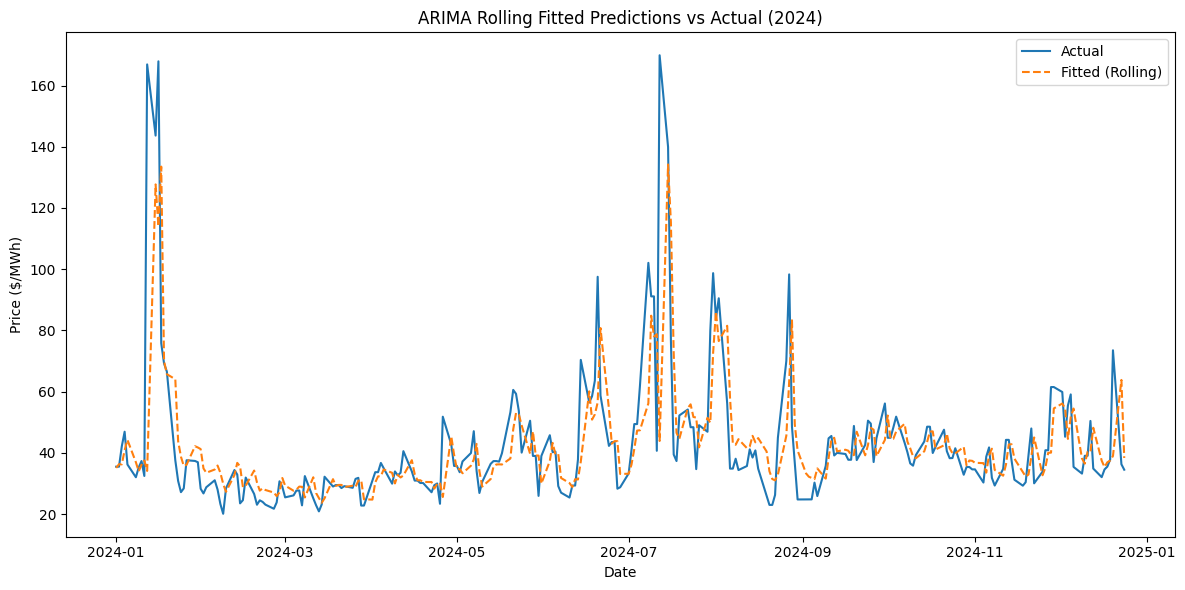

In [127]:
plt.figure(figsize=(12,6))
plt.plot(test, label='Actual')
plt.plot(pred_series_3, label='Fitted (Rolling)', linestyle='--')
plt.title('ARIMA Rolling Fitted Predictions vs Actual (2024)')
plt.xlabel('Date')
plt.ylabel('Price ($/MWh)')
plt.legend()
plt.tight_layout()
plt.show()

In [128]:
mse = mean_squared_error(test, pred_series_3)
mae = mean_absolute_error(test, pred_series_3)
rmse = np.sqrt(mse)
print(f'Rolling Fitted MSE: {mse:.2f}')
print(f'Rolling Fitted MAE: {mae:.2f}')
print(f'Rolling Fitted RMSE: {rmse:.2f}')

Rolling Fitted MSE: 268.74
Rolling Fitted MAE: 8.50
Rolling Fitted RMSE: 16.39


##### ARIMA(1,1,1) with Seasonal Dummies Forecast Evaluation

The ARIMA(1,1,1) model with seasonal dummy variables provides the best forecast performance among the specifications considered. The inclusion of is_summer and is_winter dummy variables allows the model to incorporate broad seasonal patterns in a computationally efficient way.

The rolling fitted forecast closely tracks the dynamics of the price series, capturing both broad trends and volatility clusters. Forecast evaluation shows that this model achieves lower MAE and RMSE values than both the baseline ARIMA(1,1,1) and the more complex ARIMA(3,1,4) model. Moreover, it outperforms the naive benchmark across all error metrics.

These results reinforce the appeal of the seasonal dummy variable approach, balancing simplicity, interpretability, and performance, and we retain this specification for our final modelling and forecast analysis.

## Reflection on LLM usage
There was limited use of LLMs in this project. Such models were used primarily to
generate boilerplate code and to identify and eliminate error sources. In our experience,
these tasks represent a strong cost-benefit opportunity for LLM usage, as they
maximize time savings while imposing minimal risks to code quality and our
understanding of the code.

Boilerplate code generation was identified as a promising application for LLMs because
(1) there is typically sufficient training data for generic code, (2) boilerplate code is not
usually logically complex (so the code produced is unlikely to be opaque to us despite
us not having written it ourselves), and (3) the bottleneck for creating such code tends
to be typing speed rather than conceptual reasoning. In practice, we used LLMs for
tasks such as setting up plotting and basic I/O functions. This freed up time to focus on
the more empirical and theoretical aspects of the project.

When encountering errors in the code whose source was not immediately obvious, we
often relied on LLMs to parse lengthy or cryptic error messages. By summarizing and
interpreting these error texts, LLMs saved considerable time, reduced frustration, and
helped us concentrate on problem-solving rather than menial troubleshooting.

At the same time, we were mindful of the limitations of LLMs, particularly when dealing
with more complex or domain-specific logic, as this would carry higher risks of
misunderstandings or oversights. Carefully validating LLM-generated content and taking
ownership of core logic and functions were crucial for preserving code quality and
coherence. Although targeted use of LLMs helped us work more efficiently and focus on
higher-level tasks, it is equally important to consider not just how LLMs are used, but
also when we rely on them, ensuring we maintain a solid understanding of our own
code and its underlying logic.